<a href="https://colab.research.google.com/github/mightymiklas/dibbitydabadoo/blob/main/BitcoinTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Bitcoin Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1) 
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from one of the largest Bit‐
coin exchanges in terms of average daily volume traded—Bitstamp (https://
www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [95]:
# Load libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


<a id='1.2'></a>
## 2.2. Loading the Data

In [96]:
btc_path = Path("bitstamp_flipped.csv")
btc_dataset = pd.read_csv(btc_path, index_col='date', 
                          infer_datetime_format = True, 
                          parse_dates= True)
                        




In [97]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [98]:
# shape
btc_dataset.shape

(2672, 7)

In [99]:
# peek at data
set_option('display.width', 100)
btc_dataset.tail(5)

,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06


In [100]:
btc_dataset.head()

,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,
2014-11-28,BTC/USD,363.59,381.34,360.57,376.28,3.221e+06,8617.15
2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746e+06,7245.19
2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.146e+06,3046.33
2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.521e+06,6660.56
2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.594e+06,6832.53


In [101]:
# describe data
set_option('precision', 3)
btc_dataset.describe()

,open,high,low,close,Volume BTC,Volume USD
count,2672.000,2672.000,2672.000,2672.000,2.672e+03,2.672e+03
mean,11918.914,12269.099,11516.848,11934.418,1.320e+07,6.113e+07
std,16406.581,16874.089,15851.549,16415.597,4.698e+07,1.069e+08
min,162.000,212.840,152.400,162.000,0.000e+00,0.000e+00
25%,656.997,666.577,646.037,658.890,5.213e+03,9.595e+03
50%,6444.120,6585.745,6338.175,6450.455,1.457e+04,2.398e+07
75%,10842.405,11177.003,10527.515,10850.455,3.361e+06,8.036e+07
max,67547.490,69000.000,66250.000,67559.000,7.723e+08,1.446e+09


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [102]:
#Checking for any null values and removing the null values'''
print('Null Values =',btc_dataset.isnull().values.any())

Null Values = False


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [103]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
btc_dataset['short_mavg'] = btc_dataset['close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
btc_dataset['long_mavg'] = btc_dataset['close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
btc_dataset['signal'] = np.where(btc_dataset['short_mavg'] > btc_dataset['long_mavg'], 1.0, 0.0)

In [104]:
btc_dataset.tail()


,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal
date,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0


<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [105]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(btc_dataset["close"].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
btc_dataset['EMA10'] = EMA(btc_dataset, 10)
btc_dataset['EMA30'] = EMA(btc_dataset, 30)
btc_dataset['EMA200'] = EMA(btc_dataset, 200)
btc_dataset.head()



#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)

btc_dataset['RSI10'] = RSI(btc_dataset['close'], 10)
btc_dataset['RSI30'] = RSI(btc_dataset['close'], 30)
btc_dataset['RSI200'] = RSI(btc_dataset['close'], 200)

btc_dataset.tail()
#dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
#dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
#dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
#dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
#dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
#dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200
date,,,,,,,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859


In [106]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(btc_dataset['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
btc_dataset['MA21'] = MA(btc_dataset, 10)
btc_dataset['MA63'] = MA(btc_dataset, 30)
btc_dataset['MA252'] = MA(btc_dataset, 200)
btc_dataset.tail()

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016


In [107]:
btc_dataset.tail(10)

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,
2022-03-13,BTC/USD,38798.68,39312.50,37595.62,37790.54,737.880,2.788e+07,39054.818,40161.725,0.0,39258.113,40023.642,45055.411,41.795,44.924,49.002,39054.818,40201.727,48746.478
2022-03-14,BTC/USD,37763.37,39913.42,37567.19,39665.71,1439.768,5.711e+07,39103.833,40113.287,0.0,39332.221,40000.549,45001.782,49.920,47.776,49.409,39103.833,40115.880,48710.525
2022-03-15,BTC/USD,39688.55,39896.13,38142.35,39302.70,1638.684,6.440e+07,39092.424,40049.960,0.0,39326.854,39955.527,44945.075,48.465,47.286,49.333,39092.424,40023.379,48661.536
2022-03-16,BTC/USD,39302.80,41693.97,38865.67,41142.76,5987.104,2.463e+08,39362.811,40017.306,0.0,39657.019,40032.122,44907.241,55.733,49.977,49.730,39362.811,39976.794,48622.573
2022-03-17,BTC/USD,41142.76,41497.24,40449.06,40963.22,1657.762,6.791e+07,39657.486,39981.564,0.0,39894.510,40092.193,44867.997,54.893,49.721,49.691,39657.486,39856.152,48583.346
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481


In [108]:
#excluding columns that are not needed for our prediction.

btc_dataset_dr = btc_dataset.drop(['symbol','high','low','open', 'short_mavg','long_mavg'], axis=1)

In [109]:
btc_dataset_dr = btc_dataset_dr.dropna(axis=0)

In [110]:
btc_dataset_dr.tail()

,close,Volume BTC,Volume USD,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252
date,,,,,,,,,,,,,
2022-03-18,41794.37,2125.123,8.882e+07,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300
2022-03-19,42235.31,976.889,4.126e+07,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696
2022-03-20,41242.14,1061.353,4.377e+07,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640
2022-03-21,41043.14,1779.498,7.304e+07,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481
2022-03-22,41732.03,210.062,8.766e+06,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016


<a id='3.4'></a>
## 4.4. Data Visualization

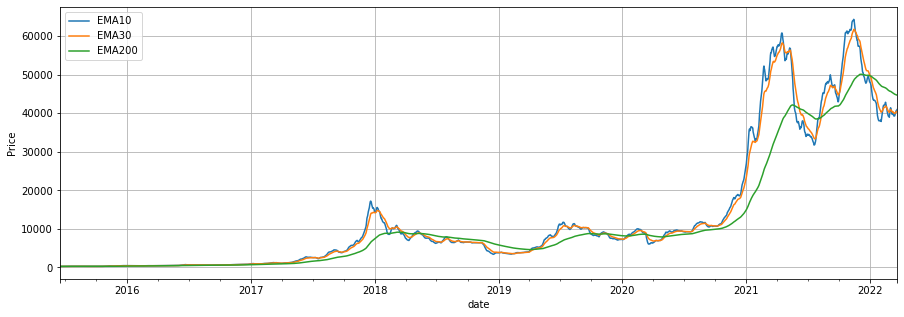

In [141]:
#Reminder to put something meaningful here!

btc_dataset_dr[['EMA10','EMA30', 'EMA200']].plot(grid=True, figsize=(15,5), ylabel='Price')
plt.show()

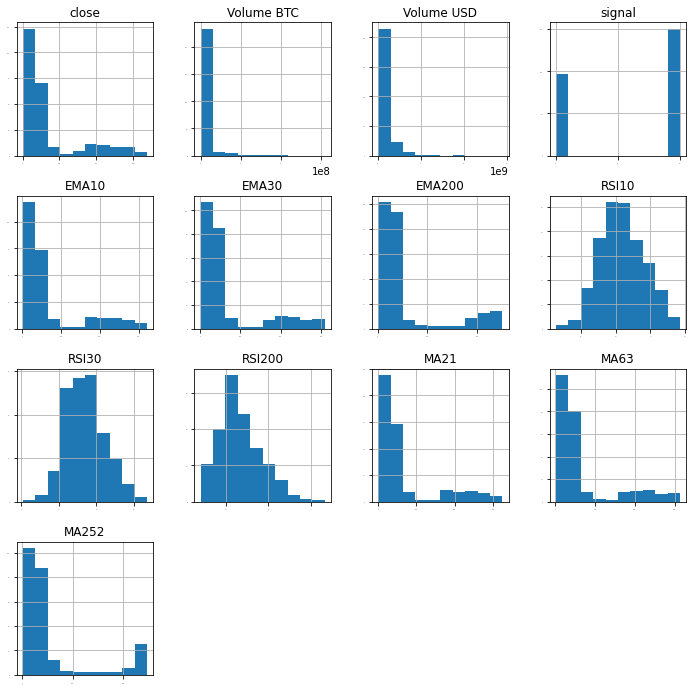

In [112]:
# histograms
btc_dataset_dr.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

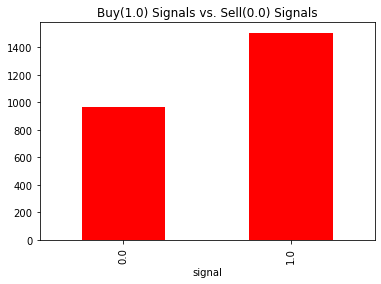

In [145]:
btc_dataset_dr.groupby(['signal']).size().plot(kind='bar', color='red', title = ("Buy(1.0) Signals vs. Sell(0.0) Signals"))
plt.show()

In [143]:
y.value_counts()

1.0    1505
0.0     967
Name: signal, dtype: int64

According to this chart, the number of buy signals outnumbered sell signals 61% to 39%

<AxesSubplot:title={'center':'Correlation Matrix'}>

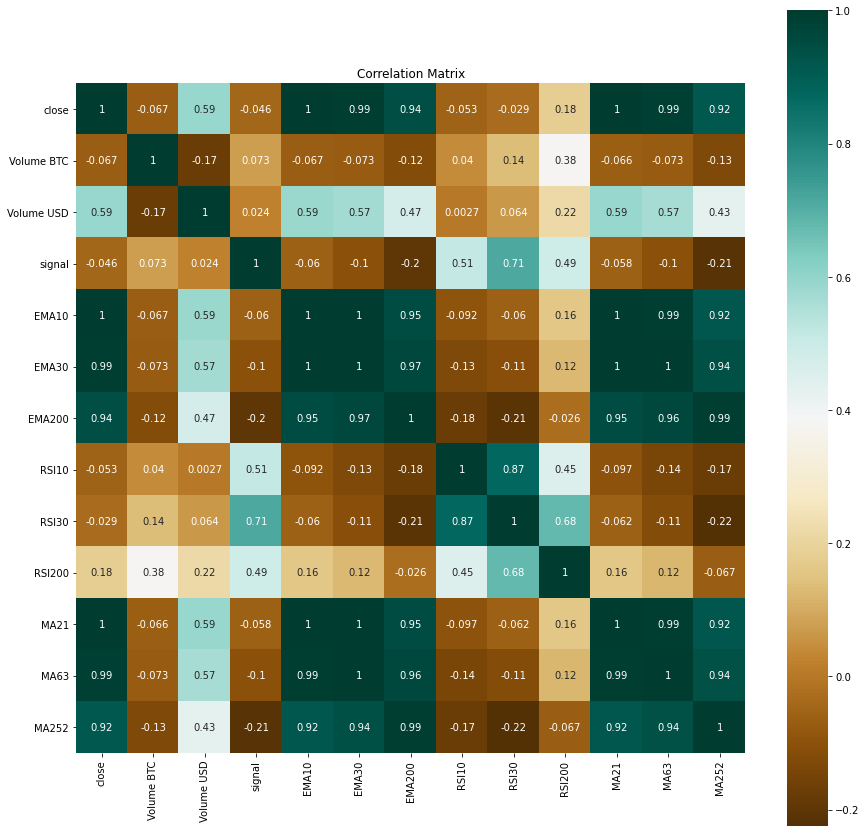

In [146]:
# correlation
correlation = btc_dataset_dr.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='BrBG')

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [115]:
X = btc_dataset_dr[['EMA10','EMA30', 'EMA200']].shift().dropna()

# Display sample data
display(X.head())
display(X.tail())


,EMA10,EMA30,EMA200
date,,,
2015-06-17,233.739,232.113,246.337
2015-06-18,235.929,232.995,246.331
2015-06-19,238.140,233.969,246.351
2015-06-20,239.100,234.578,246.318
2015-06-21,240.116,235.231,246.299


,EMA10,EMA30,EMA200
date,,,
2022-03-18,39894.510,40092.193,44867.997
2022-03-19,40239.939,40202.011,44837.414
2022-03-20,40602.734,40333.192,44811.522
2022-03-21,40718.989,40391.833,44776.006
2022-03-22,40777.926,40433.853,44738.863


In [116]:
#is copy needed?
y = btc_dataset_dr['signal']


In [117]:
from pandas.tseries.offsets import DateOffset
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(years=6)
training_end_delta = training_end + DateOffset(days=1)

print(training_end_delta)

2015-06-17 00:00:00
2021-06-18 00:00:00


In [118]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.tail()

,EMA10,EMA30,EMA200
date,,,
2021-06-13,36276.775,39585.251,40979.077
2021-06-14,36774.408,39548.381,40959.521
2021-06-15,37457.750,39611.891,40955.275
2021-06-16,37951.154,39647.993,40947.476
2021-06-17,38024.397,39564.509,40921.670


In [119]:
X_test = X.loc[training_end_delta:]
y_test = y.loc[training_end_delta:]

X_test.head()

,EMA10,EMA30,EMA200
date,,,
2021-06-18,38037.721,39469.875,40893.571
2021-06-19,37638.135,39235.689,40843.287
2021-06-20,37250.667,38995.133,40790.190
2021-06-21,36948.686,38775.432,40738.444
2021-06-22,35982.408,38314.705,40647.854


In [120]:
#module
from sklearn.preprocessing import StandardScaler


# Create a StandardScaler instance
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train.tail()

,EMA10,EMA30,EMA200
date,,,
2021-06-13,36276.775,39585.251,40979.077
2021-06-14,36774.408,39548.381,40959.521
2021-06-15,37457.750,39611.891,40955.275
2021-06-16,37951.154,39647.993,40947.476
2021-06-17,38024.397,39564.509,40921.670


In [121]:
from sklearn.metrics import classification_report

#Train SVM

svm_model = svm.SVC()

svm_model = svm_model.fit(X_train_scaled, y_train)

training_signal_predictions = svm_model.predict(X_train_scaled)

training_signal_predictions[:10]

training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       808
         1.0       0.84      0.85      0.84      1385

    accuracy                           0.80      2193
   macro avg       0.79      0.78      0.79      2193
weighted avg       0.80      0.80      0.80      2193



In [122]:
#Test SVM 

testing_signal_predictions = svm_model.predict(X_test_scaled)

testing_report = classification_report(y_test, testing_signal_predictions)

print(testing_report)

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72       158
         1.0       0.00      0.00      0.00       120

    accuracy                           0.57       278
   macro avg       0.28      0.50      0.36       278
weighted avg       0.32      0.57      0.41       278



In [123]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [128]:
#Train LR Model

model_lr = lr.fit(X_train_scaled, y_train)

train_signal_predictions_lr = model_lr.predict(X_train_scaled)

training_report_lr = classification_report(y_train, train_signal_predictions_lr)

print(training_report_lr)

              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74       808
         1.0       0.84      0.87      0.85      1385

    accuracy                           0.81      2193
   macro avg       0.80      0.79      0.80      2193
weighted avg       0.81      0.81      0.81      2193



In [129]:
#Test LR Model

test_signal_predictions_lr = model_lr.predict(X_test_scaled)

test_report_lr = classification_report(y_test, test_signal_predictions_lr)
print(test_report_lr)

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       158
         1.0       1.00      0.03      0.05       120

    accuracy                           0.58       278
   macro avg       0.79      0.51      0.39       278
weighted avg       0.76      0.58      0.44       278



In [131]:
# Import Modules
from sklearn.metrics import confusion_matrix,classification_report

# Print confusion matrix
print(confusion_matrix(y_test, test_signal_predictions_lr))

[[158   0]
 [117   3]]
